In [1]:
from typing import Callable, Optional
import matplotlib.pyplot as plt
from solver import apply as fsolver
from dataclasses import dataclass
from numba import njit
import numpy as np
import time
import os

dpi = 300
fsize = (10, 6)
iterations = 100
plt.style.use("ggplot")

In [2]:

@dataclass
class Table:
    x: np.ndarray
    y: np.ndarray
    name: str
    n: int
    time: float
    solution: Optional[Callable] = None

    def __post_init__(self):
        self.h = self.x[1] - self.x[0]

    def relative_error_mean(self) -> float:
        if self.solution is None:
            raise ValueError("Solution function is not provided.")
        solution = self.solution(self.x)
        relative_errors = np.abs((solution - self.y) / solution)
        return np.mean(relative_errors)

    def get_error(self) -> float:
        if self.solution is None:
            raise ValueError("Solution function is not provided.")
        solution = self.solution(self.x)
        error = np.abs(solution - self.y)
        return np.linalg.norm(error[-1])


In [3]:
def benchmark_time(f: Callable, a: float, b: float, n_arr: list[int], y0: float, methods: list[str], iterations: int):
    for method in methods:
        fsolver(method, f, a, b, n_arr[0], y0)

    results: list[Table] = []

    for method in methods:
        for n in n_arr:
            start = time.perf_counter()
            for _ in range(iterations):
                x, y = fsolver(method, f, a, b, n, y0)
            end = time.perf_counter()
            time_per_iteration = (end - start) / iterations

            results.append(Table(x, y, method, n, time_per_iteration))

    plot_benchmark_timings(results)

def plot_benchmark_timings(results: list[Table]):
    # Group results by method
    results_by_method = {}
    for result in results:
        if result.name not in results_by_method:
            results_by_method[result.name] = []
        results_by_method[result.name].append(result)

    # Plot the results
    plt.figure(figsize=fsize, dpi=dpi)
    plt.title("Execution Time")
    plt.xlabel("Number of Points")
    plt.ylabel("Time (s)")
    plt.xscale("log")
    plt.yscale("log")

    for method, results in results_by_method.items():
        x = [result.n for result in results]
        y = [result.time for result in results]
        plt.scatter(x, y)
        plt.plot(x, y, label=method)
    
    plt.legend()
    plt.savefig(f"outputs/timings-{dpi}dpi.png")
    plt.close()


In [4]:
def benchmark_accuracy(f: Callable, a: float, b: float, n_arr: list[int], y0: float, methods: list[str], axislabels: list[str], F: Optional[Callable] = None):
    results = []
    # Group by the number of points
    for n in n_arr:
        for method in methods:
            x, y = fsolver(method, f, a, b, n, y0)
            results.append(Table(x, y, method, n, y, F))

    if F:
        export_effective_order(n_arr, results)
        export_relative_errors_to_latex(n_arr, results)

    # Plot each method by the number of points
    for n in n_arr:
        plt.figure(figsize=fsize, dpi=dpi)
        plt.clf()
        plt.title(f"Solution with {n} points")
        plt.xlabel(axislabels[0])
        plt.ylabel(axislabels[1])

        method_x = None
        for method in results:
            if method.n == n:
                plt.plot(method.x, method.y, label=method.name, linestyle="dashed")
                plt.scatter(method.x, method.y)
            method_x = method.x
        if F:
            plt.plot(method_x, F(method_x), label="Exact Solution", color="black", alpha=0.6)

        plt.legend()
        plt.savefig(f"outputs/solution_{n}_{dpi}dpi.png")
        plt.show()


def export_relative_errors_to_latex(n_arr: list[int], results: list[Table]):
    with open("outputs/relative_errors.tex", "w", encoding="utf-8") as f:
        f.write(f"\\begin{{tabular}}{{|l|{'|'.join(['c' for _ in n_arr])}|}}\n")
        f.write(f"\\hline\n")
        f.write(f"Method & {' & '.join([str(n) for n in n_arr])}\\\\\n")
        f.write(f"\\hline\n")

        results_by_method = {}
        for result in results:
            if result.name not in results_by_method:
                results_by_method[result.name] = []
            results_by_method[result.name].append(result)

        for method, results in results_by_method.items():
            f.write(f"{method} ")
            for n in n_arr:
                for result in results:
                    if result.n == n:
                        f.write(f"& {result.relative_error_mean():.2e} ")
            f.write(f"\\\\\n")
        f.write(f"\\hline\n")
        f.write(f"\\end{{tabular}}\n")

        plt.figure(figsize=fsize, dpi=dpi)
        plt.title("Relative Error")
        plt.xlabel("Number of points")
        plt.ylabel("Relative Error")
        plt.xscale("log")
        plt.yscale("log")

        for method, results in results_by_method.items():
            x = [result.n for result in results]
            y = [result.relative_error_mean() for result in results]
            plt.scatter(x, y)
            plt.plot(x, y, label=method)
        plt.legend()
        plt.savefig(f"outputs/relative_errors-{dpi}dpi.png")


def export_effective_order(n_arr: list[int], results: list[Table]):
    with open("outputs/effective_order.tex", "w", encoding="utf-8") as f:
        f.write(f"\\begin{{tabular}}{{|l|{'|'.join(['c' for _ in n_arr])}|}}\n")
        f.write(f"\\hline\n")
        f.write(f"Method & {' & '.join([str(n) for n in n_arr])}\\\\\n")
        f.write(f"\\hline\n")

        results_by_method = {}
        for result in results:
            if result.name not in results_by_method:
                results_by_method[result.name] = []
            results_by_method[result.name].append(result)

        for method, results in results_by_method.items():
            y_1 = results[-1].get_error()
            y_2 = results[1].get_error()
            h_1 = results[-1].h
            h_2 = results[1].h
            order = (np.log(y_2 / y_1) / np.log(h_2 / h_1))
            f.write(f"{method} & {order:.5f}\\\\\n")
        f.write(f"\\hline\n")
        f.write(f"\\end{{tabular}}\n")


In [5]:
def solver(f: Callable, a: float, b: float, n_arr: list[int], y0: float, axisl, F: Callable = None):
    # Running once to JIT the functions.
    fsolver('Implicit Euler', f, a, b, 10, y0)

    methods = ["Explicit Euler",
               "Implicit Euler",
               "Modified Midpoint",
               "Runge-Kutta 3",
               "Runge-Kutta 4"]

    benchmark_time(f, a, b, n_arr, y0, methods, iterations)
    benchmark_accuracy(f, a, b, n_arr, y0, methods, axisl, F)


# Predator-Prey Model


In [6]:
@dataclass
class PredatorPreyResult:
    time: np.ndarray
    predator: np.ndarray
    prey: np.ndarray
    method: str
    time_spent: float = 0


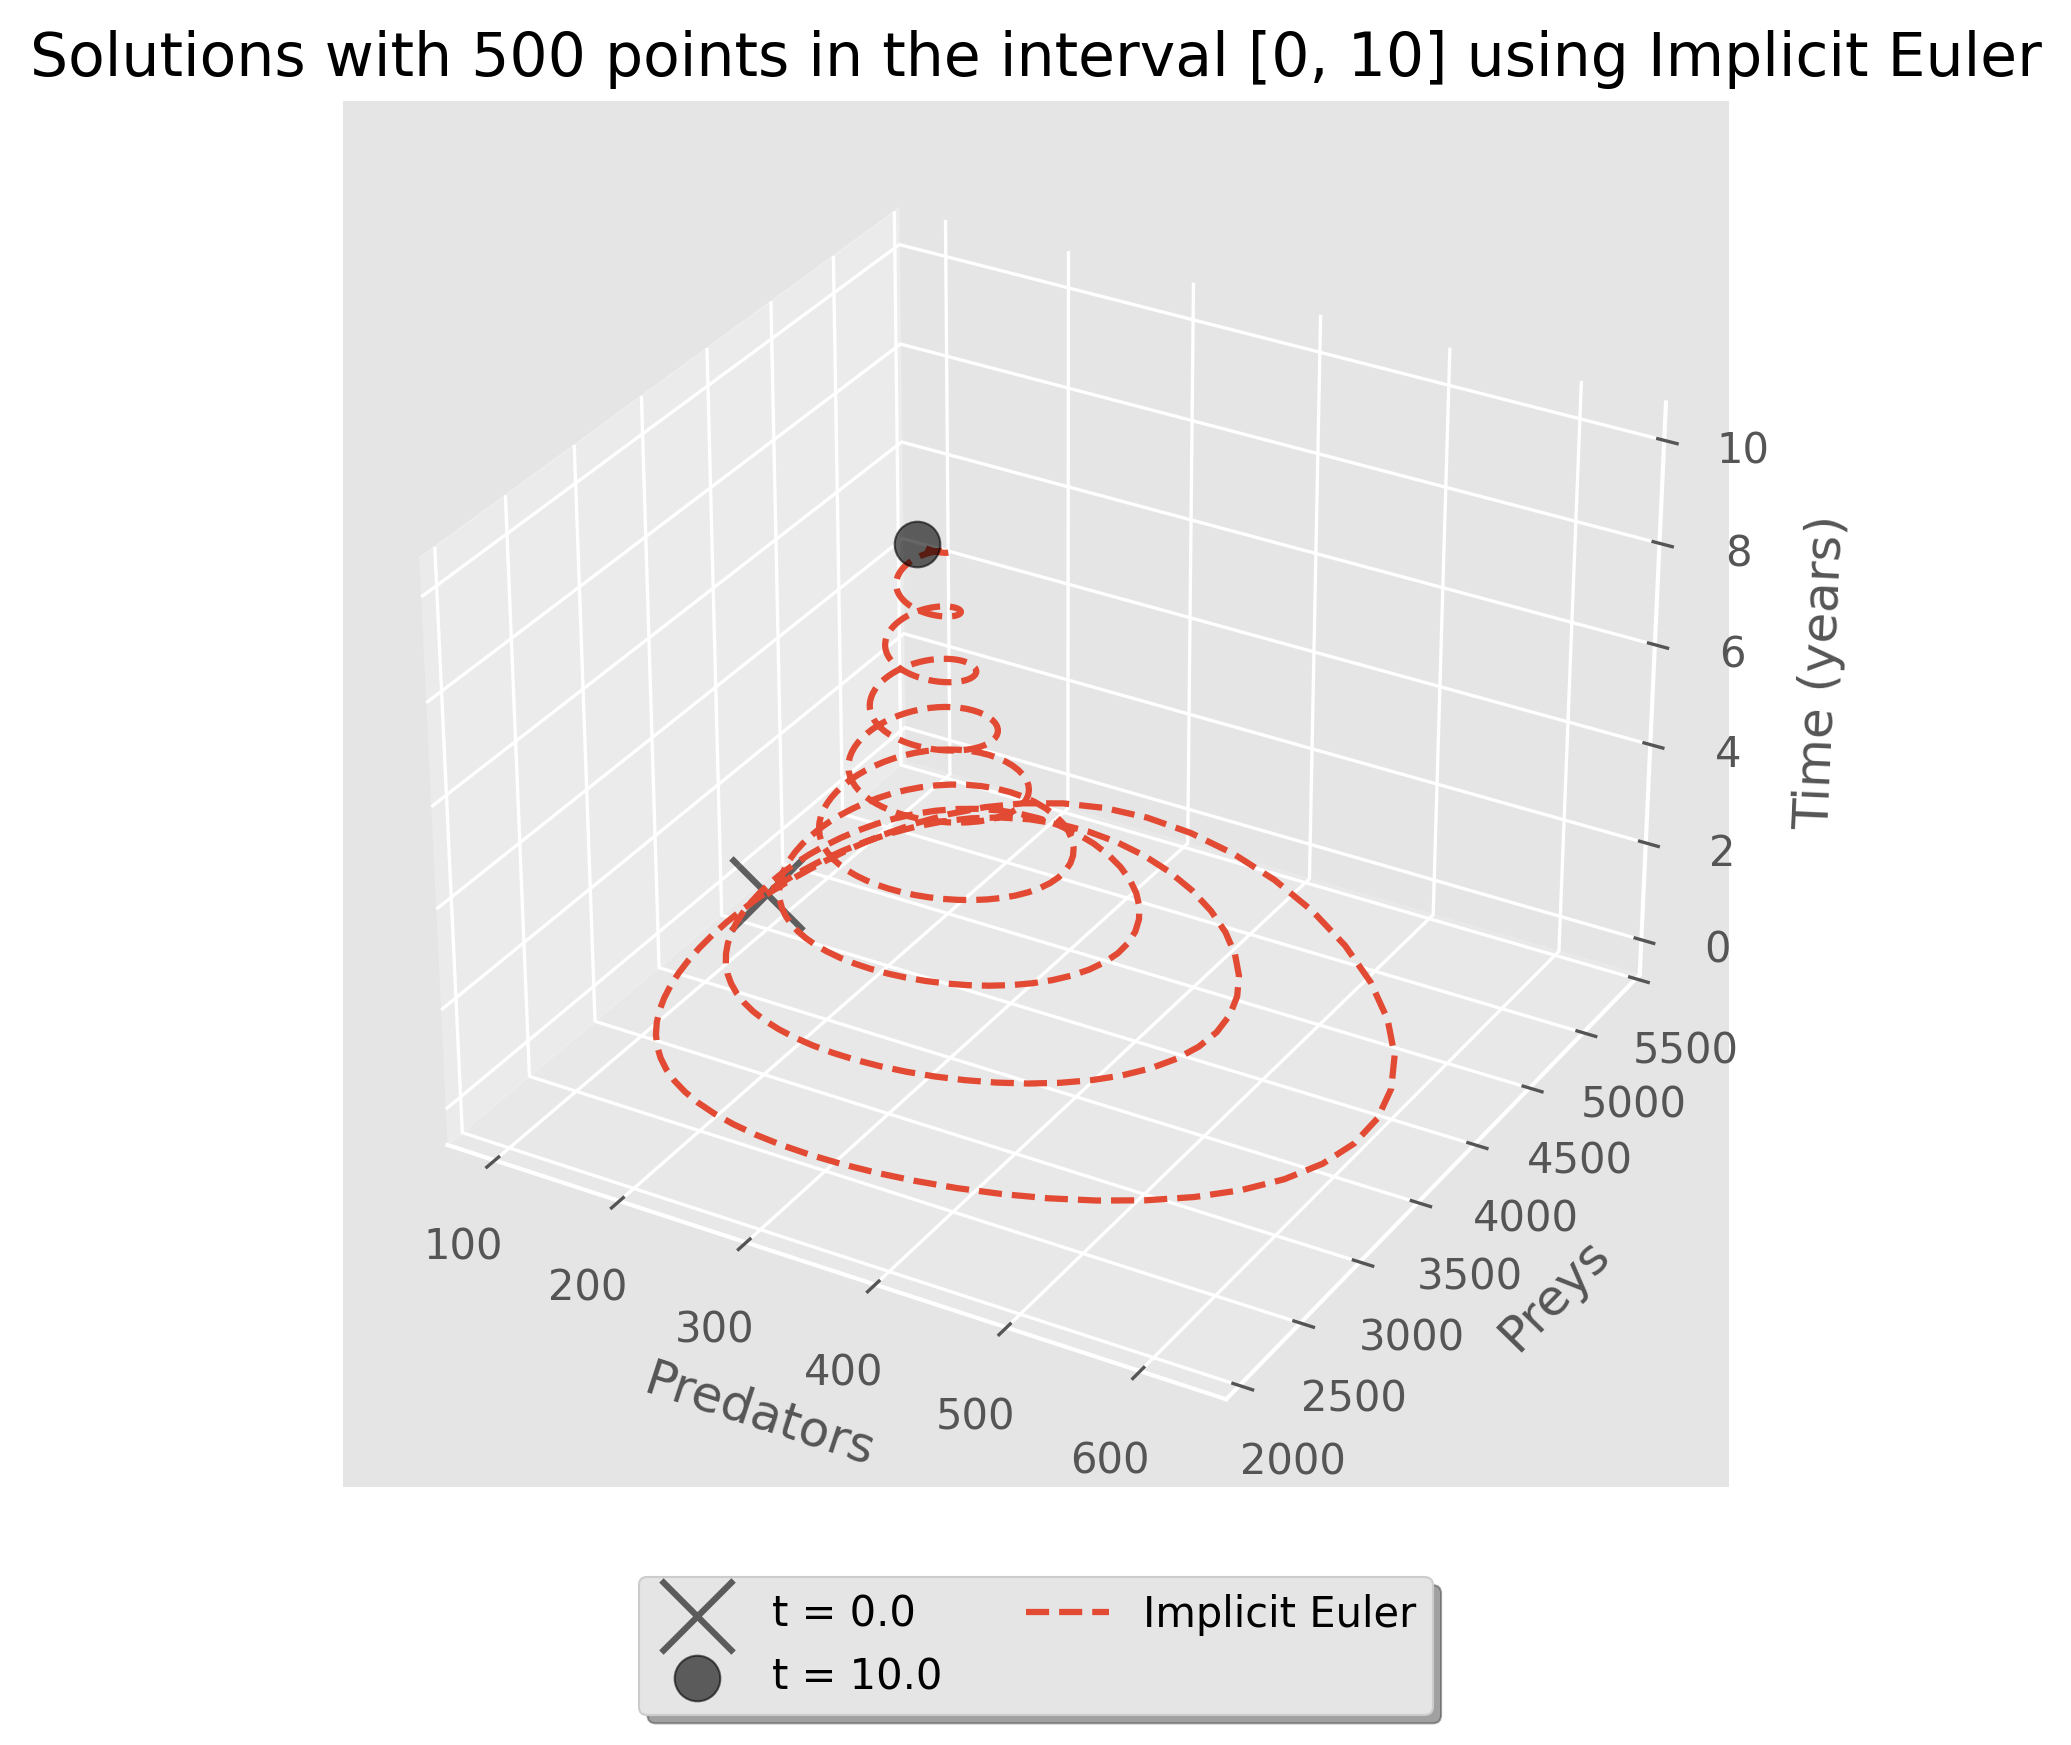

<Figure size 640x480 with 0 Axes>

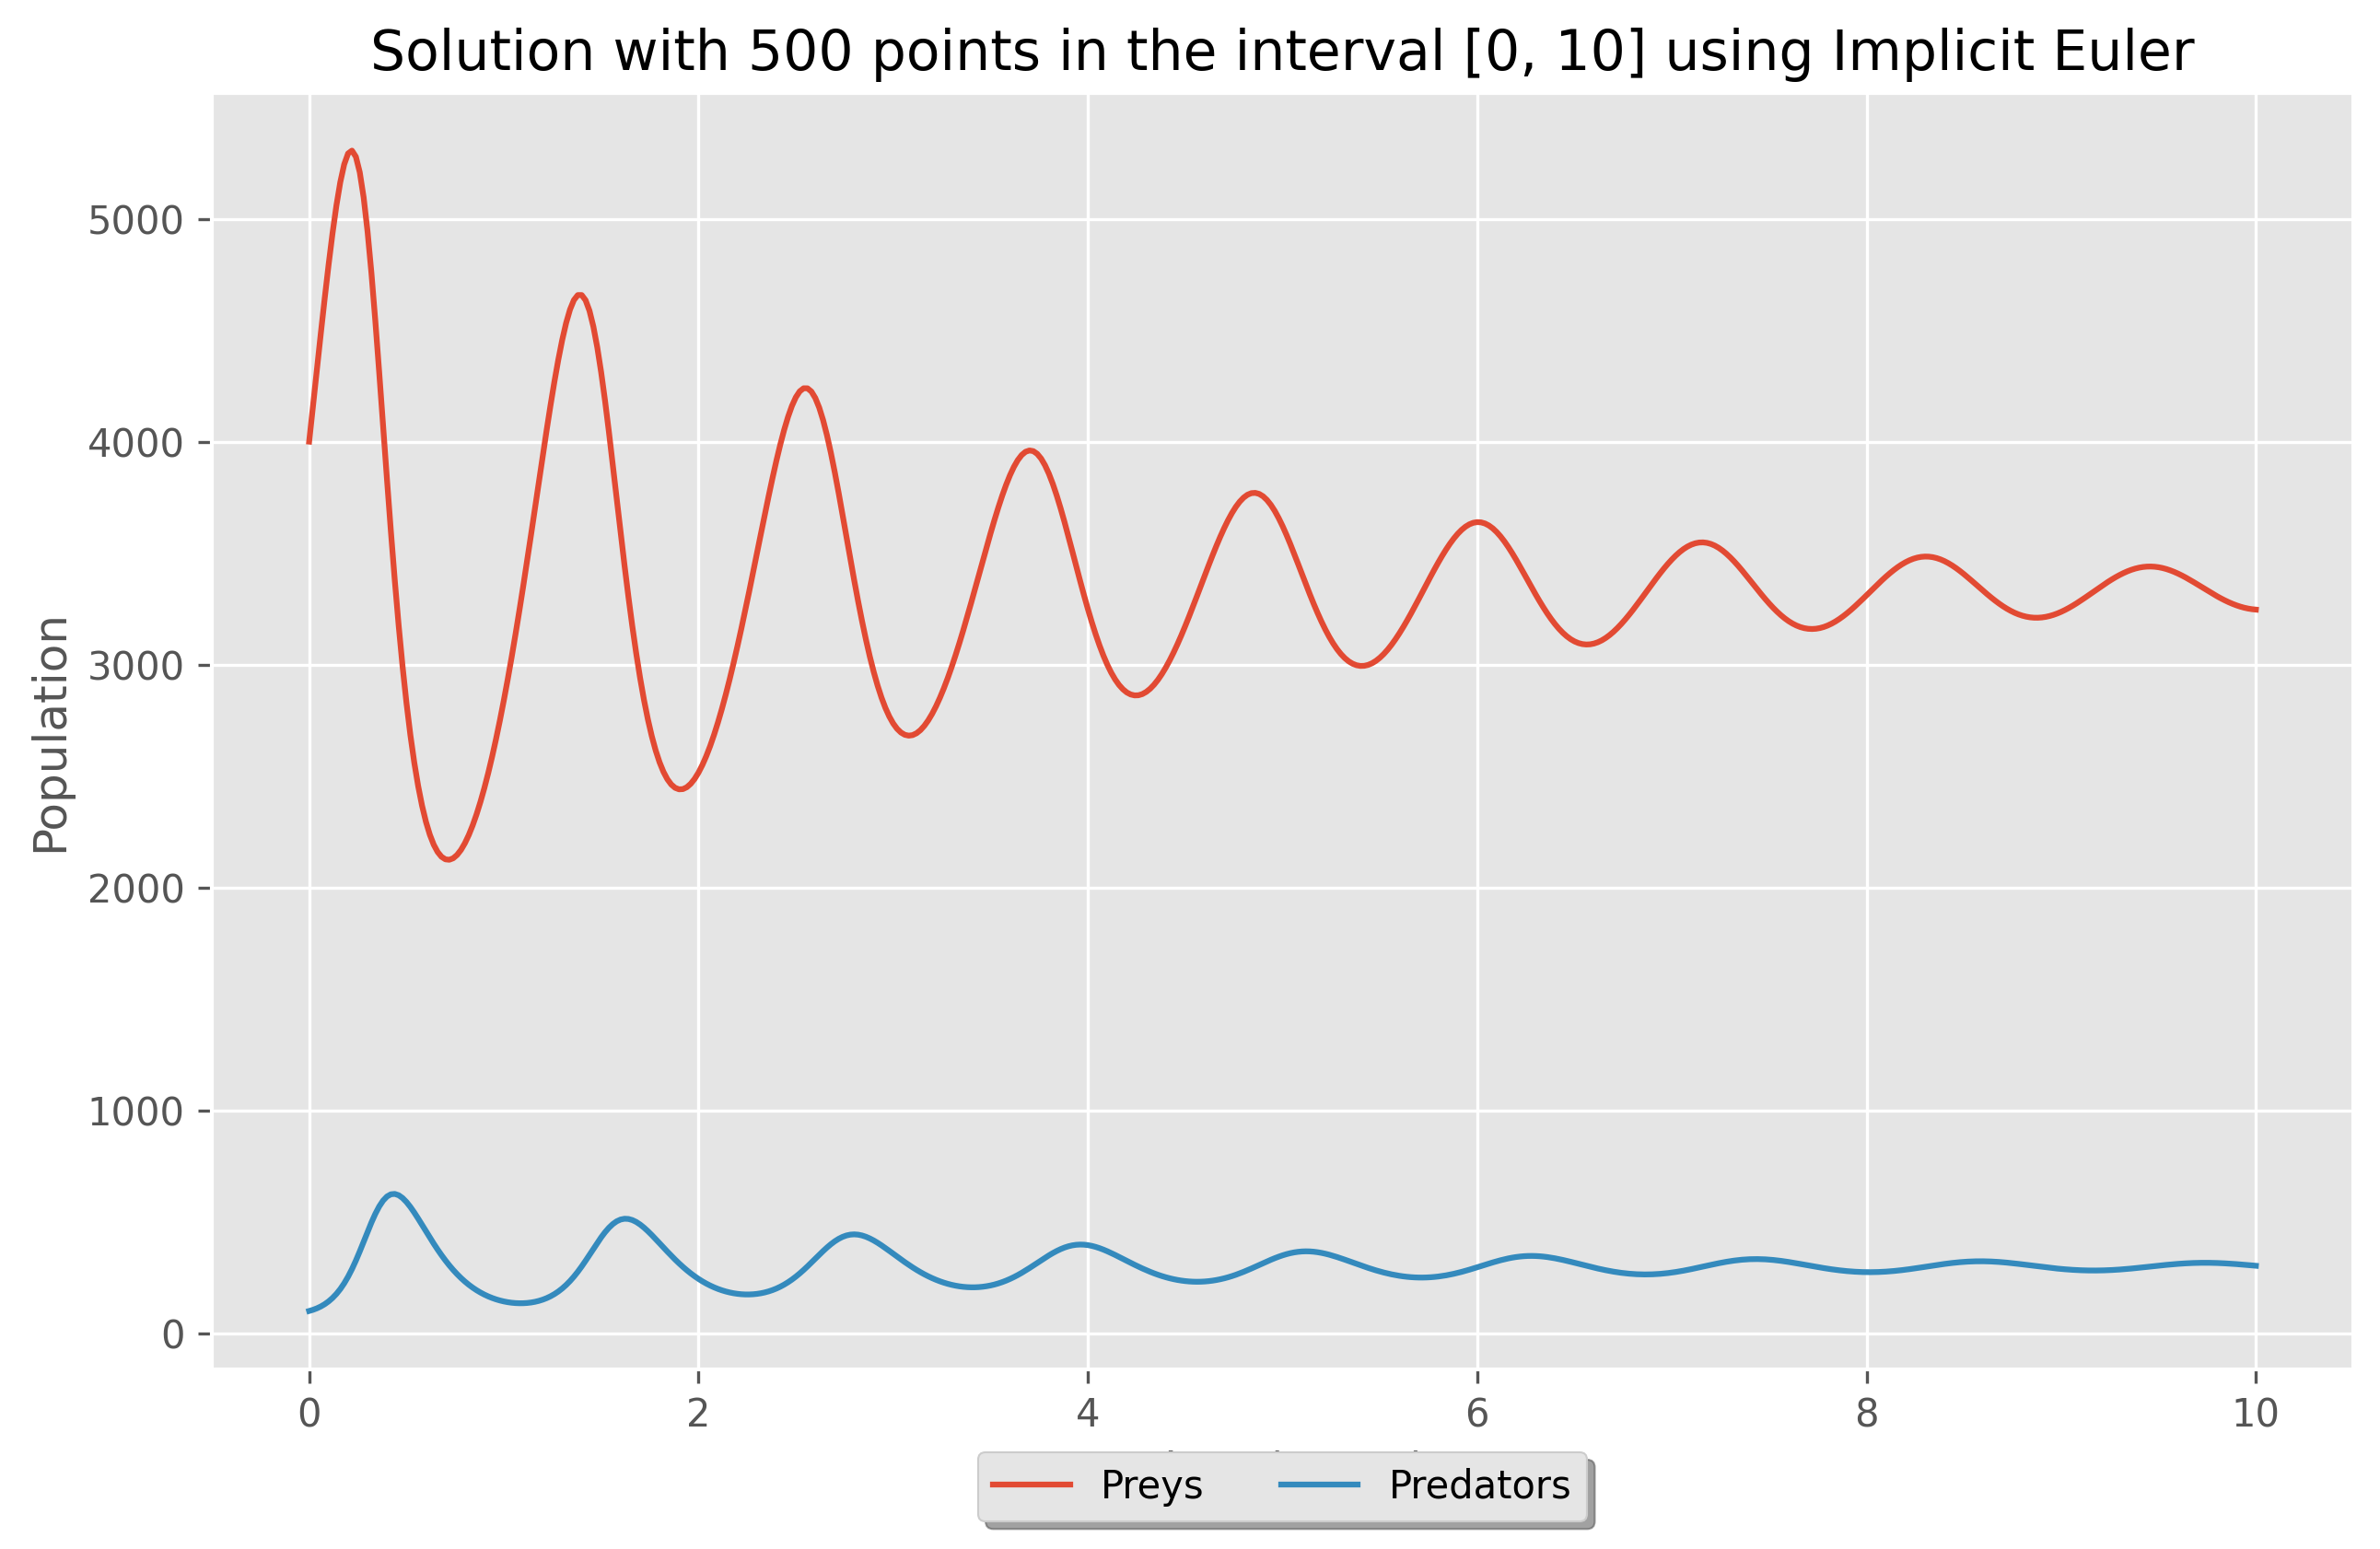

<Figure size 640x480 with 0 Axes>

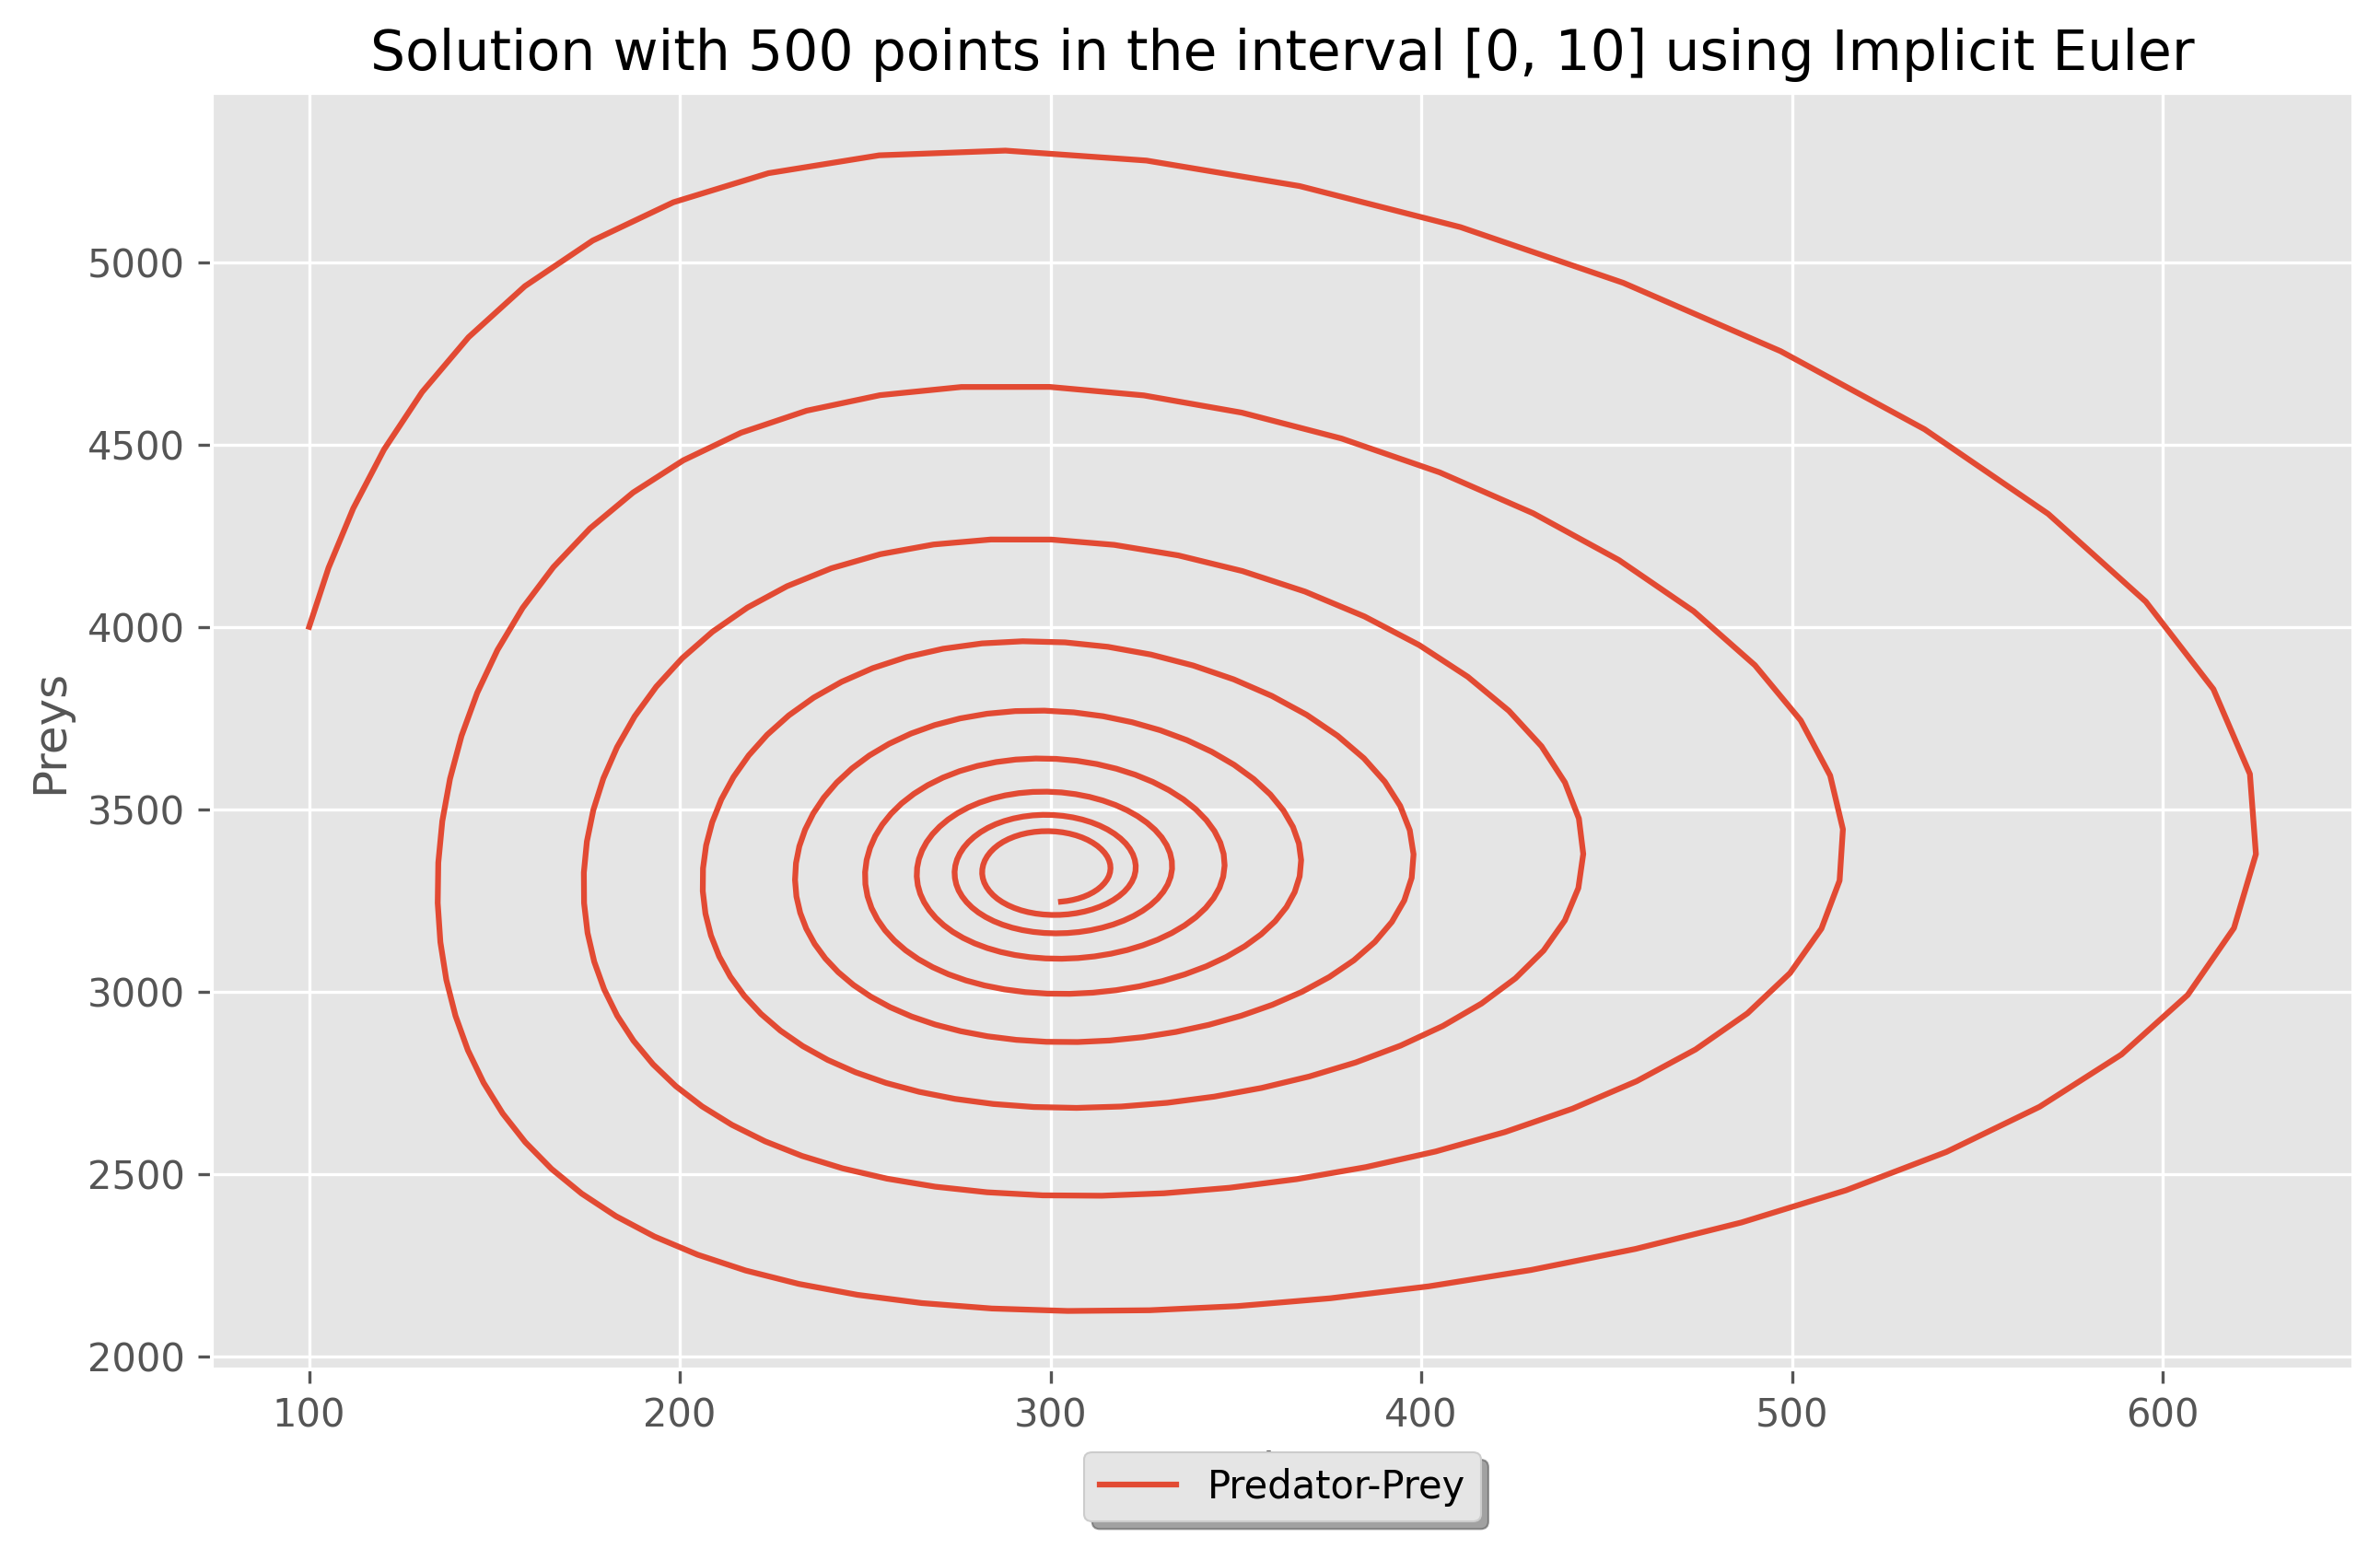

In [7]:
a, b = 0, 10
y0 = np.array([100, 4000])
n_steps = np.array([500])


rate_pred = 0.003
rate_prey = 3
prey_get_eaten = 1/100
starving = 10

@njit
def pred_prey(time, populations):
    pred, prey = populations[0], populations[1]
    d_pred = int(rate_pred * prey * pred) - int(starving * pred)
    d_prey = int(rate_prey * prey) - int(prey_get_eaten * prey * pred)
    return np.array([d_pred, d_prey])

methods = [
# "Explicit Euler",
"Implicit Euler",
# "Modified Midpoint",
# "Runge-Kutta 3",
# "Runge-Kutta 4"
]

os.makedirs("outputs", exist_ok=True)
results = []
for it, n in enumerate(n_steps):

    for method in methods:
        t, P = fsolver(method, pred_prey, a, b, n, y0)
        result = PredatorPreyResult(time=t, predator=P[:, 0], prey=P[:, 1], method=method)
        results.append(result)


    ######################################################## 3D PLOT #########################
    ax = plt.figure(figsize=fsize, dpi=dpi).add_subplot(projection="3d")
    ax.set_title(f"Solutions with {n} points in the interval [{a}, {b}] using {method}")
    for result in results:
        pred, prey, time_ = result.predator, result.prey, result.time
        method = result.method
        # Plot the initial condition
        ax.scatter(pred[0], prey[0], time_[0], label=f"t = {time_[0]}", alpha=0.6, marker='x', s=300, c='black')
        # Plot the final condition as an arrow
        ax.scatter(pred[-1], prey[-1], time_[-1], label=f"t = {time_[-1]}", alpha=0.6, marker="o", s=120, c='black')
        ax.plot(pred, prey, time_, label=method, linestyle="dashed")

    ax.set_xlabel("Predators")
    ax.set_ylabel("Preys")
    ax.set_zlabel("Time (years)")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
    plt.savefig(f"outputs/predator_prey-{dpi}dpi-{method.replace(' ', '_')}-{n} points.png")
    plt.show()

    ######################################################## 2D PLOT #########################
    plt.clf()
    plt.figure(figsize=fsize, dpi=dpi)
    plt.title(f"Solution with {n} points in the interval [{a}, {b}] using {method}")
    for result in results:
        pred, prey, time_ = result.predator, result.prey, result.time
        method = result.method
        plt.plot(time_, prey, label=f"Preys")
        plt.plot(time_, pred, label=f"Predators")
        plt.xlabel("Time (years)")
        plt.ylabel("Population")

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
    plt.savefig(f"outputs/predator_prey-{dpi}dpi-{method.replace(' ', '_')}-{n}points-2d.png")
    plt.show()
    ######################################################## 2D PLOT (UP) #########################
    plt.clf()
    plt.figure(figsize=fsize, dpi=dpi)
    plt.title(f"Solution with {n} points in the interval [{a}, {b}] using {method}")
    for result in results:
        pred, prey = result.predator, result.prey
        method = result.method
        plt.plot(pred, prey, label=f"Predator-Prey")
        plt.xlabel("Predators")
        plt.ylabel("Preys")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
    plt.savefig(f"outputs/predator_prey-{dpi}dpi-{method.replace(' ', '_' )}-{n}points-2d-up.png")
    plt.show()


In [8]:
a, b = 0, 10
y0 = np.array([100, 4000])
n_steps = np.array([500, 2500, 12500])

rate_pred = 0.003
rate_prey = 3
prey_get_eaten = 1/100
starving = 10

@njit(cache=True)
def pred_prey(time, populations):
    pred, prey = populations[0], populations[1]
    d_pred = int(rate_pred * prey * pred) - int(starving * pred)
    d_prey = int(rate_prey * prey) - int(prey_get_eaten * prey * pred)
    return np.array([d_pred, d_prey])

methods = [
"Explicit Euler",
"Implicit Euler",
"Modified Midpoint",
"Runge-Kutta 3",
"Runge-Kutta 4"
]
results = []
for method in methods:
        t, P = fsolver(method, pred_prey, a, b, n, y0)


In [9]:
for it, n in enumerate(n_steps):
    itera = 1
    for method in methods:
        start = time.perf_counter()
        for t_spent in range(itera):
            t, P = fsolver(method, pred_prey, a, b, n, y0)
        end = time.perf_counter()
        spent = (end - start) / itera
        result = PredatorPreyResult(time=t, predator=P[:, 0], prey=P[:, 1], method=method, time_spent=spent)
        results.append(result)


# Plotting

<Figure size 640x480 with 0 Axes>

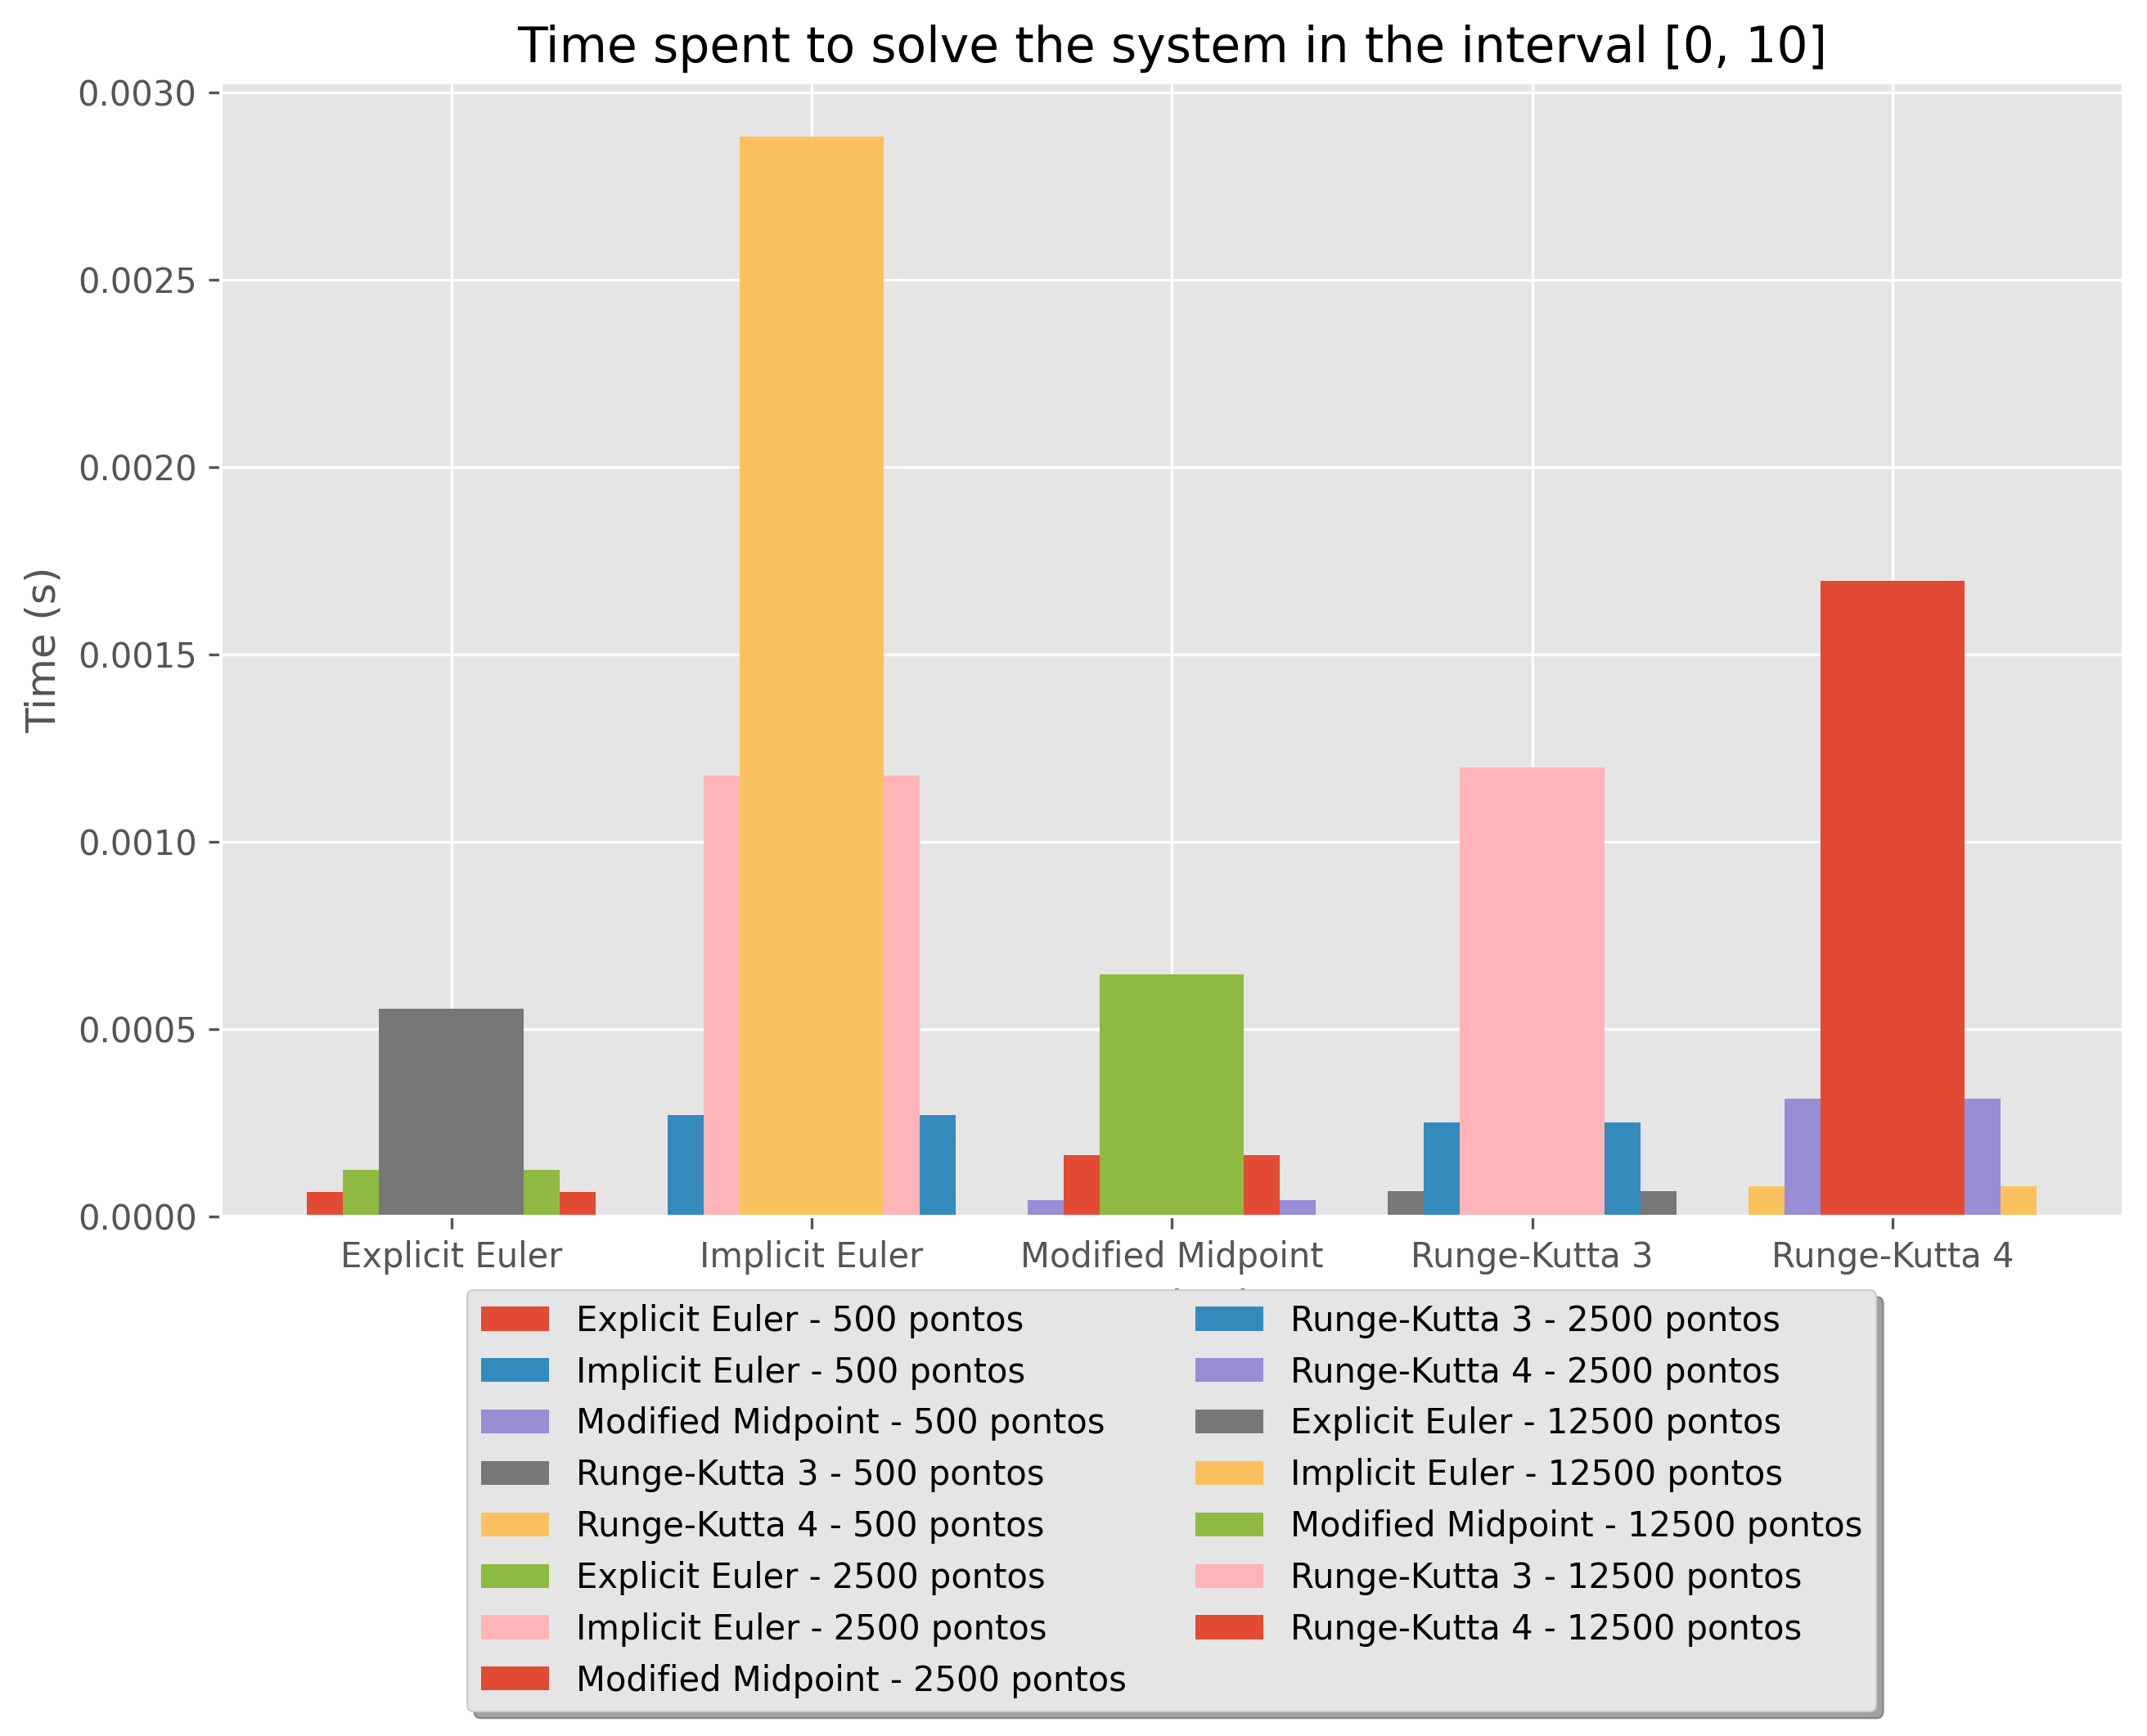

In [10]:
# Plot the time spent
plt.clf()
plt.figure(figsize=fsize, dpi=dpi)
plt.title(f"Time spent to solve the system in the interval [{a}, {b}]")

def plot_result_time(result: PredatorPreyResult, method: str):
    n = len(result.predator) - 1
    if n == 500:
        plt.bar(method, result.time_spent, label=f"{method} - {n} pontos", width=0.8)
    elif n == 2500:
        plt.bar(method, result.time_spent, label=f"{method} - {n} pontos", width=0.6)
    else:
        plt.bar(method, result.time_spent, label=f"{method} - {n} pontos", width=0.4)
    
for result in results:
    plot_result_time(result, result.method)


plt.xlabel("Method")
plt.ylabel("Time (s)")
plt.legend()
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.savefig(f"outputs/predator_prey-{dpi}dpi-time-comparison-{n}points-time.png")
plt.show()

